In [9]:
import os
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

import hls4ml
from hls4ml.converters.keras_to_hls import parse_default_keras_layer
from hls4ml.model.attributes import ConfigurableAttribute, TypeAttribute
from hls4ml.model.types import FixedPrecisionType, RoundingMode, SaturationMode
from hls4ml.model.attributes import Attribute

# Source the Vivado path
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

np.random.seed(0)
tf.random.set_seed(0)

# Locals
from crop_utils import create_training_data, plot_borders_norm

# Sample/testing data

In [11]:
IMAGE_SIZE = (50, 80)
NUM_BLOBS = 1
CROP_BOX_ROWS = 20
CROP_BOX_COLS = 20

images.shape = (num_samples, image_size[1], image_size[0], 1) =  (2, 50, 80, 1)
crop_coords.shape = (num_samples, num_blobs, 4) =  (2, 1, 4)


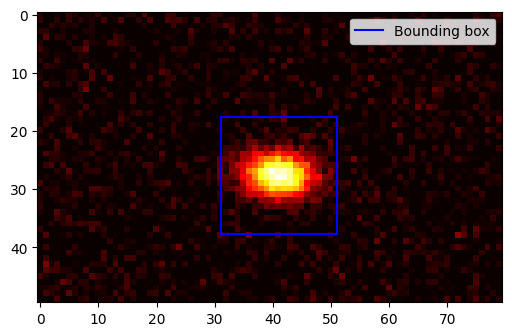

In [12]:
num_samples = 2  # Number of training samples
images, gauss_params, crop_coords = create_training_data(num_samples, image_size = IMAGE_SIZE, num_blobs = NUM_BLOBS, crop_box_rows = CROP_BOX_ROWS, crop_box_cols = CROP_BOX_COLS, noise_std=0.05)

print("images.shape = (num_samples, image_size[1], image_size[0], 1) = ", images.shape)
print("crop_coords.shape = (num_samples, num_blobs, 4) = ", crop_coords.shape)
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.imshow(images[0].squeeze(), cmap='hot', vmin=0, vmax=1)
plot_borders_norm(ax, crop_coords[0], image_size=IMAGE_SIZE)
plt.show(fig)

### Save data for verilog testing

float-32

In [15]:
tb_image = images[0]
np.save(os.path.join("../testbench/tb_data", f"tb_image_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{NUM_BLOBS}crops_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_float32.npy"), tb_image)

tb_crop_coords = crop_coords[0]
np.save(os.path.join("../testbench/tb_data", f"tb_crop_coords_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{NUM_BLOBS}crops_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_float32.npy"), tb_crop_coords)

ap_fixed<10,2>

In [ ]:
from fxpmath import Fxp
n_word = 16
n_frac = 14
tb_image_ap_fixed_10_2 = Fxp(tb_image, signed=False, n_word=n_word, n_frac=14).bin()
with open(os.path.join("../testbench/tb_data", f"tb_image_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{NUM_BLOBS}crops_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{n_word}_{n_word-n_frac}.bin"), 'w') as f:
    for row in tb_image_ap_fixed_10_2:
        for val in row:
            f.write(str(val[0]))
            f.write('\n')

tb_crop_coords_ap_fixed_10_2 = Fxp(tb_crop_coords, signed=False, n_word=10, n_frac=8)
with open(os.path.join("../testbench/tb_data", f"tb_crop_coords_{IMAGE_SIZE[0]}x{IMAGE_SIZE[1]}_{NUM_BLOBS}crops_{CROP_BOX_ROWS}x{CROP_BOX_COLS}_ap_fixed_{n_word}_{n_word-n_frac}.bin"), 'w') as f:
    for row in tb_crop_coords_ap_fixed_10_2.bin():
        for val in row:
            f.write(str(val))
            f.write('\n')

# 1. Define Keras CropLayer and Model

In [6]:
class CropLayer(layers.Layer):
    def __init__(self, image_shape, crop_shape, num_boxes, **kwargs):
        super(CropLayer, self).__init__(**kwargs)
        self.image_shape = image_shape
        self.crop_shape = crop_shape
        self.num_boxes = num_boxes

    def call(self, inputs):
        image = inputs
        batch_size = tf.shape(image)[0]

        crop_boxes_hc = np.array([[[0.3536409 , 0.21394373, 0.7536409 , 0.46394372], [0.33071667, 0.5321235 , 0.73071665, 0.7821235 ]],[[0.3536409 , 0.21394373, 0.7536409 , 0.46394372], [0.33071667, 0.5321235 , 0.73071665, 0.7821235 ]]], dtype=np.float32)
        crop_boxes = tf.convert_to_tensor(crop_boxes_hc)
        
        crop_boxes = tf.reshape(crop_boxes, (batch_size * self.num_boxes, 4))  # Flatten the crop_boxes tensor
        box_indices = tf.range(batch_size)
        box_indices = tf.repeat(box_indices, repeats=self.num_boxes)
        
        cropped_images = tf.image.crop_and_resize(
            image, crop_boxes, box_indices, self.crop_shape
        )
        
        return cropped_images
    
    def get_config(self):
        # Breaks serialization and parsing in hls4ml if not defined
        return super().get_config()

    
def build_crop_model(image_shape, crop_size, num_boxes):
    inputs = layers.Input(shape=image_shape)
    # crop_boxes = layers.Input(shape=(num_boxes, 4))
    x = CropLayer(image_shape, crop_size, num_boxes)(inputs)
    model = Model(inputs=[inputs], outputs=x)
    return model

2024-11-14 12:08:32.110821: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-14 12:08:32.111057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-14 12:08:32.111166: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-11-14 12:08:32.111238: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-11-14 12:08:32.111308: W tensorf

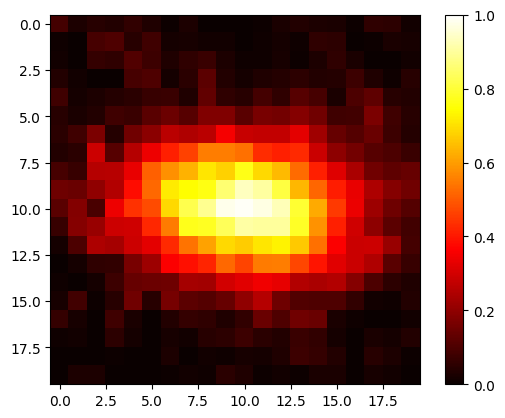

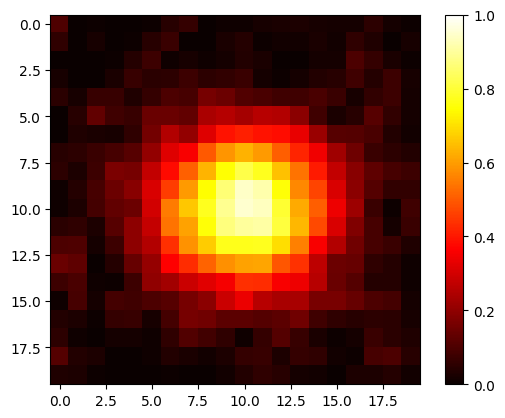

In [7]:
model_input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
model = build_crop_model(model_input_shape, (CROP_BOX_ROWS, CROP_BOX_COLS), NUM_BLOBS)
cropped_images = model([images]).numpy().squeeze()
for i in range(2):
    plt.figure()
    plt.imshow(cropped_images[i], cmap='hot', vmin=0, vmax=1)
    plt.colorbar()
    plt.show()
    plt.close()

## 2. Define, register frontend hls4ml objects

In [8]:
def parse_crop_layer(keras_layer, input_names, input_shapes, data_reader):
    print(f"input_names = {input_names}")
    print(f"input_shapes = {input_shapes}")
    
    assert 'CropLayer' in keras_layer['class_name']
    
    crop_shape = None
    for l in data_reader.model.layers:
        if l.name == keras_layer['name']:
            print(f"l{l}")
            crop_shape = l.crop_shape
    if crop_shape is None:
        raise AttributeError(f"Could not find crop_shape attribute for layer {keras_layer['name']}")

    layer = parse_default_keras_layer(keras_layer, input_names)
    img_shape = input_shapes[0]

    num_boxes = 2
    num_channels = img_shape[-1]
    output_shape = [None, num_boxes, crop_shape[0], crop_shape[1], num_channels]

    layer["num_boxes"] = num_boxes
    layer["num_channels"] = num_channels
    layer["img_shape"] = img_shape
    max_idx = np.multiply(np.multiply(images.shape[1], images.shape[2]), images.shape[3])
    layer["idx_t"] = f"ap_uint<{int(np.ceil(np.log2(max_idx)) + 1)}>"

    return layer, output_shape

class HCropLayer(hls4ml.model.layers.Layer):
    "hls4ml implementation of the CropLayer"
    _expected_attributes = [Attribute('crop_rows'), Attribute('crop_cols')]

    def initialize(self):
        inp_0 = self.model.get_layer_output_variable(self.inputs[0]) # Image

        crop_shape = None
        for l in self.model.config.config['KerasModel'].layers:
            if l.name == self.get_attr('name'):
                crop_shape = l.crop_shape
        if crop_shape is None:
            raise AttributeError(f"Could not find crop_shape attribute for layer {self.get_attr('name')}")
        else:
            self.set_attr('crop_rows', crop_shape[0])
            self.set_attr('crop_cols', crop_shape[1])

        num_channels = inp_0.shape[-1]
        num_channels_name = inp_0.dim_names[-1]
        num_boxes = 2 
        num_boxes_name = "NUM_BOXES"

        crop_rows = self.get_attr('crop_rows')
        crop_cols = self.get_attr('crop_cols')

        shape = [num_boxes, crop_rows, crop_cols, num_channels]
        dim_names = [num_boxes_name, f"CROP_ROWS_{self.index}", f"CROP_COLS_{self.index}", num_channels_name]
        self.add_output_variable(shape, dim_names)

hls4ml.converters.register_keras_layer_handler('CropLayer', parse_crop_layer)
hls4ml.model.layers.register_layer('CropLayer', HCropLayer)

## 3. Define, register backend hls4ml objects

In [9]:
# Templates
crop_config_template = """struct config{index} : nnet::crop_config {{
    static const unsigned in_height = {in_height};
    static const unsigned in_width = {in_width};
    static const unsigned n_chan = {n_chan};
    static const unsigned n_crop_boxes = {n_crop_boxes};
    static const unsigned crop_rows = {crop_rows};
    static const unsigned crop_cols = {crop_cols};
\\
}};\n"""

crop_function_template = "nnet::crop<{input1_t}, {index_t}, {output_t}, {config}>({input1}, {output});"

crop_include_list = ["nnet_utils/nnet_crop.h"]

class HCropLayerConfigTemplate(hls4ml.backends.template.LayerConfigTemplate):
    def __init__(self):
        super().__init__(HCropLayer)
        self.template = crop_config_template

    def format(self, node):
        params = self._default_config_params(node)

        image_input = node.get_input_variable(node.inputs[0])
        params['in_height'] = image_input.shape[0]
        params['in_width'] = image_input.shape[1]
        params['n_chan'] = image_input.shape[2]

        # crop_coords_input = node.get_input_variable(node.inputs[1])
        params['n_crop_boxes'] = 2
        params['crop_rows'] = 20
        params['crop_cols'] = 20
        return self.template.format(**params)
    
class HCropLayerFunctionTemplate(hls4ml.backends.template.FunctionCallTemplate):
    def __init__(self):
        super().__init__(HCropLayer, include_header=crop_include_list)
        self.template = crop_function_template

    def format(self, node):
        
        params = {}
        params['config'] = f'config{node.index}'
        params['input1_t'] = node.get_input_variable(node.inputs[0]).type.name
        params['output_t'] = node.get_output_variable().type.name
        params['input1'] = node.get_input_variable(node.inputs[0]).name
        params['output'] = node.get_output_variable().name

        image_input = node.get_input_variable(node.inputs[0])
        in_height = image_input.shape[0]
        in_width = image_input.shape[1]
        n_chan = image_input.shape[2]
        max_idx = in_height*in_width*n_chan
        params['index_t'] = f'ap_uint<{int(np.ceil(np.log2(max_idx)))}>'

        return self.template.format(**params)
    
backend = hls4ml.backends.get_backend('Vivado')
backend.register_template(HCropLayerConfigTemplate)
backend.register_template(HCropLayerFunctionTemplate)
p = Path("nnet_crop.h")
backend.register_source(p)

# 5. Create hls4ml.model

In [10]:
config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend="Vivado")
config['Model']['Precision']['default'] = 'ap_fixed<16,2>'

hmodel = hls4ml.converters.convert_from_keras_model(
        model,
        output_dir=str(f'hls4mlprj_CropLayer_small'),
        backend="Vivado",
        io_type='io_stream', # TODO: try io_stream
        hls_config=config #{'Model': {'Precision': 'ap_int<6>', 'ReuseFactor': 1}},
    )

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 50, 80, 1]], output shape: [None, 50, 80, 1]
input_names = ['input_1']
input_shapes = [[None, 50, 80, 1]]
l<__main__.CropLayer object at 0x7fd066a82050>
Layer name: crop_layer, layer type: CropLayer, input shapes: [[None, 50, 80, 1]], output shape: [None, 2, 20, 20, 1]
Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 50, 80, 1]], output shape: [None, 50, 80, 1]
input_names = ['input_1']
input_shapes = [[None, 50, 80, 1]]
l<__main__.CropLayer object at 0x7fd066a82050>
Layer name: crop_layer, layer type: CropLayer, input shapes: [[None, 50, 80, 1]], output shape: [None, 2, 20, 20, 1]
Creating HLS model


## 6. Compile hls4ml.model and predict

In [11]:
hmodel.compile()

Writing HLS project


Done


self.inputs: ['input_1']


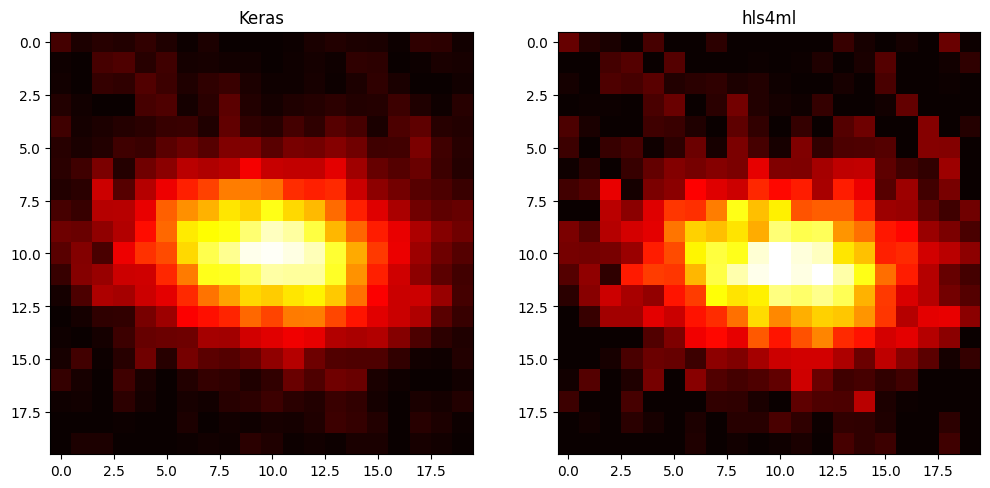

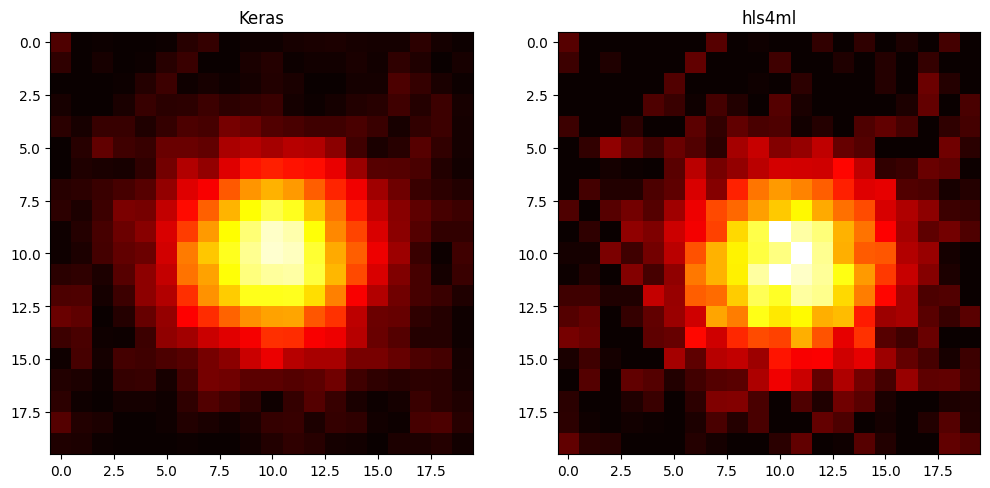

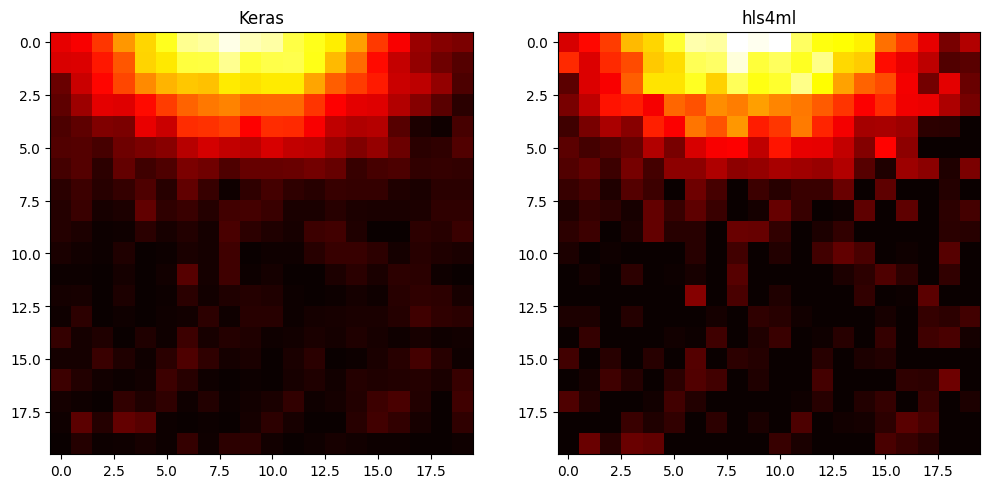

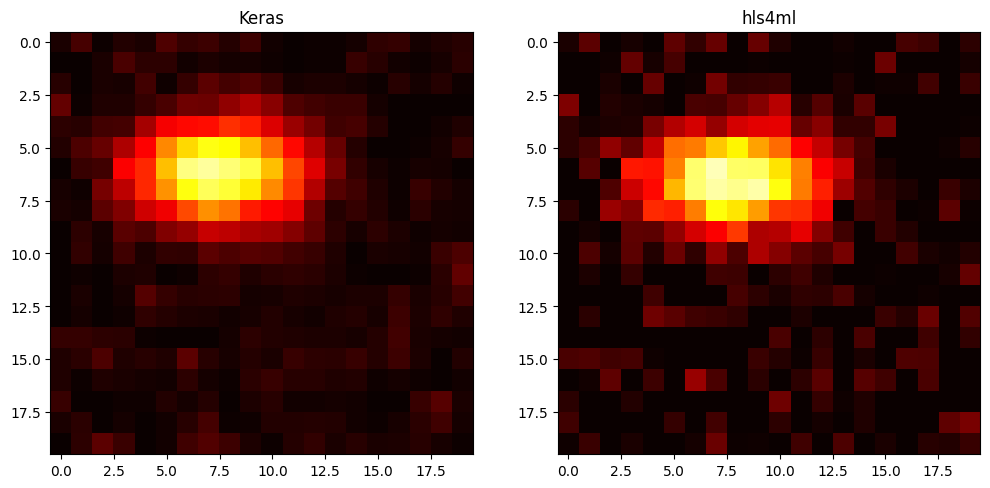

In [12]:
kpred = model(images)
kpred = np.reshape(kpred, (num_samples, NUM_BLOBS, CROP_BOX_ROWS, CROP_BOX_COLS))

hpred = hmodel.predict(np.ascontiguousarray(images)).reshape((num_samples, NUM_BLOBS, CROP_BOX_ROWS, CROP_BOX_COLS))

for i in range(num_samples):
    for j in range(NUM_BLOBS):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
        ax1.imshow(kpred[i, j], cmap='hot', vmin=0, vmax=1)
        ax1.set_title('Keras')
        ax2.imshow(hpred[i, j], cmap='hot', vmin=0, vmax=1)
        ax2.set_title('hls4ml')
        plt.show(fig)
        plt.close(fig)

In [13]:
hmodel.build(csim=False, synth=True, vsynth=True) # csim still doesn't work


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'aelabd' on host 'DESKTOP-Q0UCNGC.' (Linux_x86_64 version 5.15.133.1-microsoft-standard-WSL2) on Thu Nov 14 12:08:37 PST 2024
INFO: [HLS 200-10] On os Ubuntu 24.04 LTS
INFO: [HLS 200-10] In directory '/home/aelabd/RHEED/crop_classify/custom_hls_layer/test_conversions/hls4mlprj_CropLayer_small'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/aelabd/RHEED/crop_classify/custom_hls_layer/test_conversions/hls4mlprj_CropLayer_small/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the proj

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '2.164',
  'BestLatency': '5706',
  'WorstLatency': '5706',
  'IntervalMin': '5707',
  'IntervalMax': '5707',
  'BRAM_18K': '2',
  'FF': '211',
  'LUT': '482',
  'DSP': '0',
  'URAM': '0',
  'AvailableBRAM_18K': '5376',
  'AvailableDSP': '12288',
  'AvailableFF': '3456000',
  'AvailableLUT': '1728000',
  'AvailableURAM': '1280'},
 'VivadoSynthReport': {'LUT': '487',
  'FF': '462',
  'BRAM_18K': '1',
  'URAM': '0',
  'DSP48E': '0'}}

In [14]:
hls4ml.report.read_vivado_report(hmodel.config.config['OutputDir'])

Found 1 solution(s) in hls4mlprj_CropLayer_small/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
/tools/Xilinx/Vivado/2019.1/tps/lnx64/binutils-2.26/bin/ld: cannot find crt1.o: No such file or directory
/tools/Xilinx/Vivado/2019.1/tps/lnx64/binutils-2.26/bin/ld: cannot find crti.o: No such file or directory
/tools/Xilinx/Vivado/2019.1/tps/lnx64/binutils-2.26/bin/ld: cannot find -lpthread
/tools/Xilinx/Vivado/2019.1/tps/lnx64/binutils-2.26/bin/ld: cannot find -lm
collect2: error: ld returned 1 exit status
make: *** [Makefile.rules:402: csim.exe] Error 1
ERR: [SIM 100] 'csim_design' failed: compilation error(s).
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vivado HLS Report for 'mypr

## Save output for comparison to verilog testbench

In [15]:
np.save(os.path.join("../testbench/tb_data", "keras_pred.npy"), kpred[0])
np.save(os.path.join("../testbench/tb_data", "hls_model_pred.npy"), hpred[0])